In [1]:
from concurrent.futures import ThreadPoolExecutor
import sys
import argparse
import torch, os, random, gym, time
import numpy as np

from torch import nn
from torch.autograd import Variable
from wrapper.gym_wrapper import make_atari, wrap_deepmind
from matplotlib import pyplot as plt, gridspec
from scipy.ndimage.filters import gaussian_filter
from scipy.misc import imresize

In [2]:
lambda_reg = 0.01
n_aggregates = 20
min_val = -25
max_val = 25
agg_values = np.linspace(min_val, max_val, n_aggregates)

use_cuda = True
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

mean_pixel_image = Variable(FloatTensor(np.zeros((84, 84, 4))), requires_grad=False)

class QNetwork(nn.Module):
    def __init__(self, input_shape, output_len, hidden_dim):
        super(QNetwork, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)

        self.fc = nn.Linear(conv_out_size, hidden_dim)

        self.deconv_fc = nn.Linear(hidden_dim, conv_out_size)

        self.deconv = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_shape[0], kernel_size=8, stride=4)
        )

        # self.query_embed = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.key_matrix = nn.Parameter(torch.randn(output_len, n_aggregates, hidden_dim))
        self.register_buffer('agg_values', Variable(FloatTensor(agg_values).view(n_aggregates, 1)))

        self.init_weights()

    def forward(self, x):
        x = x.float() - mean_pixel_image
        x = x / 255.0
        x = x.permute(0, 3, 1, 2)   # NCHW format

        fx= self.conv(x).view(x.size()[0], -1)

        x_embed = self.fc(fx)

        # q = torch.mm(x_embed, torch.t(self.query_embed))
        q = x_embed

        att_keys = torch.matmul(self.key_matrix, torch.t(q))
        soft_keys = nn.Softmax(dim=1)(att_keys)

        att_values = soft_keys * self.agg_values
        att_values = att_values.sum(dim=1)

        # att_log_px = soft_keys.log()
        # att_entropy = -soft_keys * att_log_px
        # att_loss = torch.sum(att_entropy)

        reconstructed_img = self.deconv(self.deconv_fc(x_embed).view(x.size()[0], 64, 7, 7))
        # reconstruction_loss = (reconstructed_img - x).pow(2).sum()

        return torch.t(att_values), soft_keys, reconstructed_img

    def get_embed(self, x):
        x = x.float() - mean_pixel_image
        x = x / 255.0
        x = x.permute(0, 3, 1, 2)  # NCHW format

        fx = self.conv(x).view(x.size()[0], -1)

        x_embed = self.fc(fx)

        return x_embed

    def _get_conv_out(self, shape):
        o = self.conv(Variable(torch.zeros(1, *shape)))
        return int(np.prod(o.size()))

    def reconstruct_key(self, key_embed):
        return self.deconv(self.deconv_fc(key_embed).view(key_embed.size()[0], 64, 7, 7))

    def init_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
                nn.init.xavier_uniform(layer.weight.data)
                nn.init.constant(layer.bias.data, 0.0)

            if isinstance(layer, nn.Linear):
                nn.init.normal(layer.weight.data, 0, 0.1)

            if isinstance(layer, nn.Parameter):
                nn.init.normal(layer.data, 0, 0.1)

    def save_model_weights(self, suffix):
        # Helper function to save your model / weights.
        torch.save(self.state_dict(), suffix)

    def load_model_weights(self, model_file, strict=True):
        model_dict = torch.load(model_file)
        model_dict.pop('agg_values')
        self.load_state_dict(model_dict,strict)

In [3]:
lambda_exp=0.001

def action_selector(q_distributions):
    means = torch.mm(q_distributions.data, FloatTensor(agg_values).view(n_aggregates, 1))
    variances = torch.mm(q_distributions.data, FloatTensor(agg_values).view(n_aggregates, 1).pow(2))
    variances = variances - means
    std_devs = variances.sqrt()

    optimistic_returns = means + lambda_exp * std_devs
    _, action = torch.max(optimistic_returns, dim=0)
    action = int(action)

    return action

def process_img(state):
    return np.array(state)

In [48]:
env_name = 'SpaceInvadersNoFrameskip-v4'
hidden_dim = 256
model_file = '/mnt/51df7bb1-bef2-4dca-ad11-aa088846cd64/github/state-aggregated-q-learning/src/models/spaceinvaders-gray/best-models/model.tar'
mean_image_file = '/mnt/51df7bb1-bef2-4dca-ad11-aa088846cd64/github/state-aggregated-q-learning/src/models/spaceinvaders-gray/mean_pixel_image.npy'


env = make_atari(env_name)
env = wrap_deepmind(env, frame_stack=True, scale=False, clip_rewards=False, episode_life=False)
n_action = env.action_space.n

meanings = env.unwrapped.get_action_meanings()

state = env.reset()
state_p = np.array(state).reshape(4, 84, 84).astype(np.float32) / 255.0

net = QNetwork(state_p.shape, n_action, hidden_dim)
if use_cuda:
    net = net.cuda()

net.load_model_weights(model_file, False)
mean_pixel_image = Variable(FloatTensor(np.load(mean_image_file)), requires_grad=False)

print('Loaded saved files')

Loaded saved files


In [49]:
map_embeddings = {}
for i in range(n_action):
    map_embeddings[i] = []

In [52]:
for iteration in range(10):
    total_reward = 0
    done = False
    episode_length = 0
    trajectory = []
    state = env.reset()

    while not done:
        trajectory.append(state)
        q_values, soft_keys, re_img = net(Variable(FloatTensor(process_img(state)[None]), volatile=True))    
        soft_keys = soft_keys[:, :, 0]
        act = action_selector(soft_keys)    
        if soft_keys[act, n_aggregates-1].cpu().data.numpy()[0] > 0.9:
            map_embeddings[act].append(net.get_embed(Variable(FloatTensor(process_img(state)[None]), volatile=True)).cpu().data.numpy())

        next_state, reward, done, _ = env.step(act)   

        state = next_state
        total_reward += reward
        episode_length += 1
    
print('Trajectory length: %d, Total Rewards: %d' % (len(trajectory), total_reward))
for i in range(n_action):
    print('Action: %s, Length: %d' % (meanings[i], len(map_embeddings[i])))

Trajectory length: 1705, Total Rewards: 1230
Action: NOOP, Length: 4
Action: FIRE, Length: 251
Action: RIGHT, Length: 42
Action: LEFT, Length: 53
Action: RIGHTFIRE, Length: 152
Action: LEFTFIRE, Length: 170


## Visualize embeddings

In [53]:
X = []
y = []

for label in range(n_action):    
# for label in [2,6,8]:
    X.append(net.key_matrix[label, n_aggregates-1, :].cpu().data.numpy())
    y.append(label + 9)
    for example in map_embeddings[label]:
        X.append(example[0,:])
        y.append(label)
        
print(len(X), len(y))

678 678


In [54]:
X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)

(678, 256) (678,)


In [55]:
import pandas as pd

feat_cols = [ 'dim'+str(i) for i in range(X.shape[1]) ]

df = pd.DataFrame(X,columns=feat_cols)
df['label'] = y
df['label'] = df['label'].apply(lambda i: str(i))

print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (678, 257)


In [56]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.23285572 0.18006983]


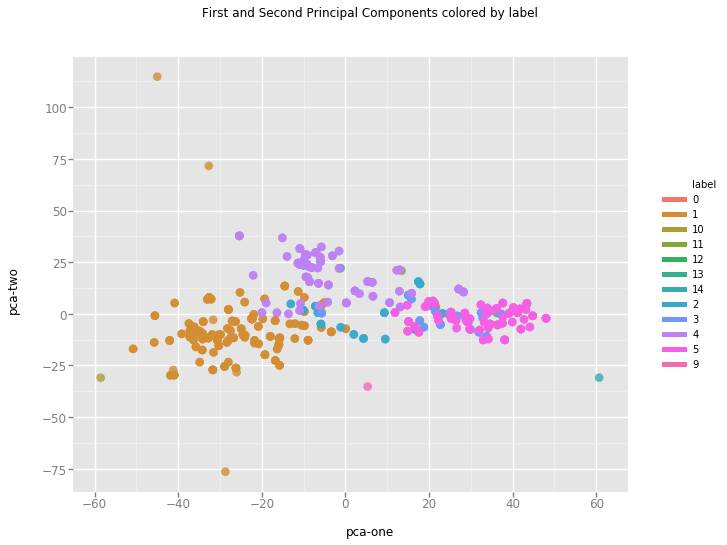

<ggplot: (8728086726201)>

In [57]:
from ggplot import *


chart = ggplot( df.loc[:,:], aes(x='pca-one', y='pca-two', color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components colored by label")
chart

In [69]:
import time

from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=75, n_iter=3000)
tsne_results = tsne.fit_transform(df.loc[:,feat_cols].values)


print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 226 nearest neighbors...
[t-SNE] Indexed 678 samples in 0.005s...
[t-SNE] Computed neighbors for 678 samples in 0.283s...
[t-SNE] Computed conditional probabilities for sample 678 / 678
[t-SNE] Mean sigma: 1.873845
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.007191
[t-SNE] Error after 3000 iterations: 0.006347
t-SNE done! Time elapsed: 60.28604578971863 seconds


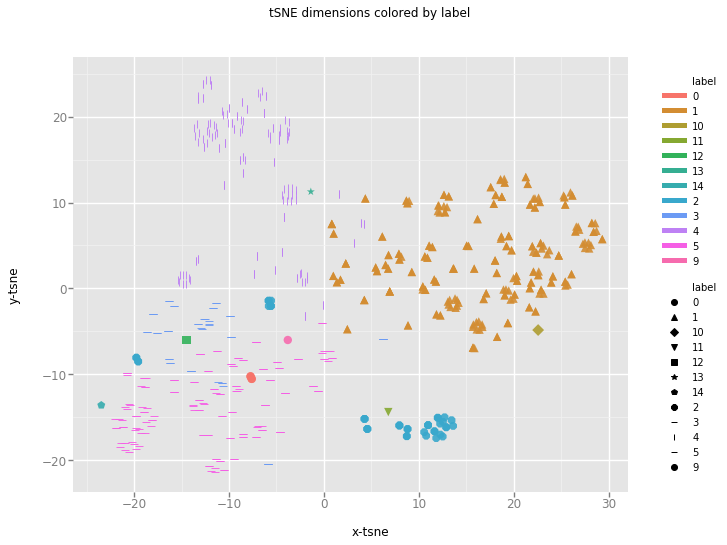

<ggplot: (-9223363308767967221)>

In [59]:
from ggplot import *

df_tsne = df.loc[:,:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label', shape='label') ) \
        + geom_point(size=70,alpha=0.9) \
        + ggtitle("tSNE dimensions colored by label")
chart

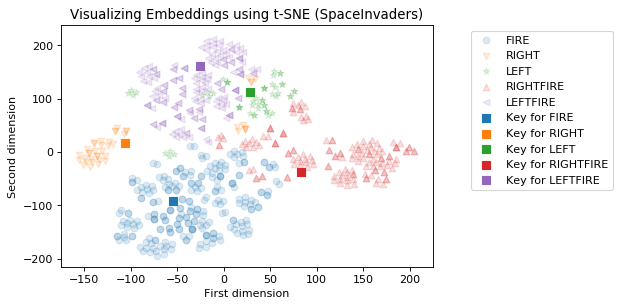

In [71]:
from matplotlib import pyplot as plt

key_idx = np.isin(y, [11,15,17])
non_key_idx = np.logical_not(key_idx)

req_ids = [1,2,3,4,5]
req_key_ids = [10,11,12,13,14]
marker_id = ['o', 'v', '*','^', '<']

plt.figure(figsize=(6, 4), dpi=80)

for i in range(5):
   plt.scatter(tsne_results[y == req_ids[i],0], tsne_results[y == req_ids[i],1], marker=marker_id[i], alpha=.15, label=meanings[req_ids[i]])
plt.gca().set_prop_cycle(None)
for i in range(5):
   plt.scatter(tsne_results[y == req_key_ids[i],0], tsne_results[y == req_key_ids[i],1], marker='s', alpha=1.0, s=50, label='Key for %s' % meanings[req_ids[i]]) 

plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.xlabel('First dimension')
plt.ylabel('Second dimension')
plt.title('Visualizing Embeddings using t-SNE (SpaceInvaders)')
plt.savefig('/home/raghu/Documents/i-DQN/spaceinvaders-tsne.png', bbox_inches='tight')
plt.show()

# plt.scatter(tsne_results[non_key_idx,0], tsne_results[non_key_idx,1], c=y[non_key_idx], alpha=.5)
# plt.scatter(tsne_results[key_idx,0], tsne_results[key_idx,1], c=y[key_idx], s=100, marker='^', alpha=1.0)
# plt.show()
